# RED NEURONAL CONVOLUCIONAL

In [1]:
pip install torch matplotlib scikit-learn


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Preprocesamiento de los datos

In [3]:
# Preprocesar los datos
file_path = 'df_CNN_todo.csv'
data = pd.read_csv(file_path)

# Separar características y etiquetas
X = data.drop(columns=['labels']).values
y = data['labels'].values

# Normalizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir los datos a tensores
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear conjuntos de datos y dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Generar arquitectura de la CNN

In [4]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        # Calcular el tamaño aplanado
        x = torch.rand(1, 1, 12166)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        self.flattened_size = x.numel()

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Añadir dimensión de canal
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn6(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [5]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [6]:
# Variables para almacenar los resultados
all_labels = []
all_probs = []
train_losses = []
test_accuracies = []

In [7]:
# Entrenamiento de la red
num_epochs = 50
best_accuracy = 0
patience = 10
trigger_times = 0

## Ejecutamos el código

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluación de la red
    model.eval()
    correct = 0
    total = 0
    epoch_labels = []
    epoch_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)[:, 1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_labels.extend(labels.cpu().numpy())
            epoch_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    test_accuracies.append(accuracy)
    
    all_labels.extend(epoch_labels)
    all_probs.extend(epoch_probs)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}')
    
    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break
    
    # Ajustar la tasa de aprendizaje
    scheduler.step()

print(f'Best Test Accuracy: {best_accuracy:.4f}')

Epoch 1/50, Loss: 0.7411, Test Accuracy: 0.4700
Epoch 2/50, Loss: 0.7192, Test Accuracy: 0.5200
Epoch 3/50, Loss: 0.7223, Test Accuracy: 0.4700
Epoch 4/50, Loss: 0.6980, Test Accuracy: 0.5300
Epoch 5/50, Loss: 0.7206, Test Accuracy: 0.4700
Epoch 6/50, Loss: 0.7106, Test Accuracy: 0.5133
Epoch 7/50, Loss: 0.6883, Test Accuracy: 0.5200
Epoch 8/50, Loss: 0.6985, Test Accuracy: 0.5000
Epoch 9/50, Loss: 0.7019, Test Accuracy: 0.5167
Epoch 10/50, Loss: 0.6935, Test Accuracy: 0.5567
Epoch 11/50, Loss: 0.6813, Test Accuracy: 0.5633
Epoch 12/50, Loss: 0.6759, Test Accuracy: 0.5633
Epoch 13/50, Loss: 0.6685, Test Accuracy: 0.5833
Epoch 14/50, Loss: 0.6670, Test Accuracy: 0.5500
Epoch 15/50, Loss: 0.6509, Test Accuracy: 0.5100
Epoch 16/50, Loss: 0.6398, Test Accuracy: 0.5700
Epoch 17/50, Loss: 0.6097, Test Accuracy: 0.5500
Epoch 18/50, Loss: 0.5874, Test Accuracy: 0.7033
Epoch 19/50, Loss: 0.5468, Test Accuracy: 0.5100
Epoch 20/50, Loss: 0.5124, Test Accuracy: 0.7400
Epoch 21/50, Loss: 0.4978, Te

## GRÁFICA ROC

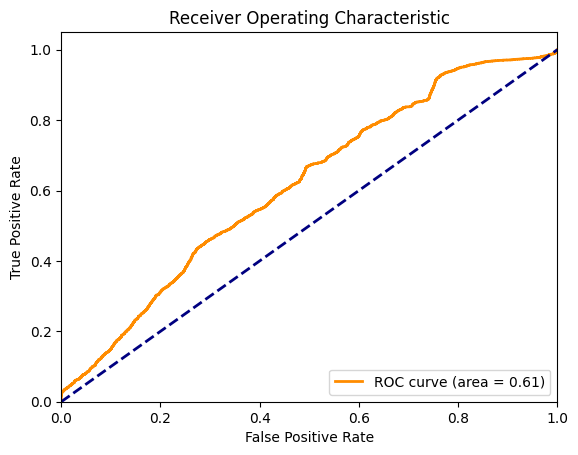

In [9]:
# Generar la gráfica ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## GRÁFICA DE ACCURACY VS ÉPOCA

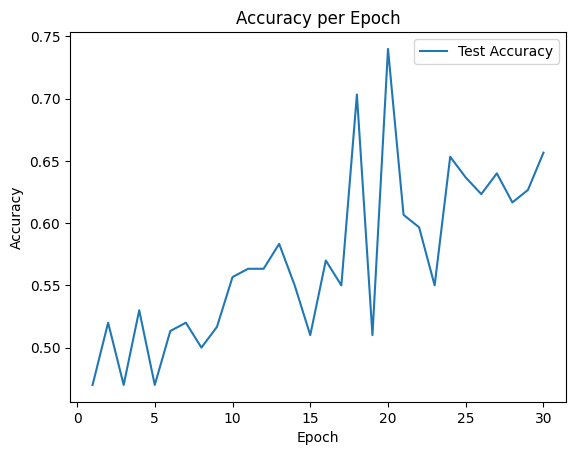

In [10]:
# Generar la gráfica de precisión por época
plt.figure()
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()